In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [ ]:
# Cell 1: imports & setup (same as earlier exp3 shown, plus explain)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp3")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp3"]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#  KFold CV training loop for Exp3 (Swin-T, strong aug, BCE)

backbone_name = cfg["backbone"]              # "swin_tiny_patch4_window7_224"
img_size = cfg["img_size"]                  # 384 (used only in transforms)
aug_type = cfg["aug"]                       # "strong"
loss_name = cfg["loss"]                     # "bce"

n_splits = cfg["n_splits"]
epochs = cfg["epochs"]
batch_size = cfg["batch_size"]
lr = cfg["lr"]
weight_decay = cfg["weight_decay"]
patience = cfg["patience"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} ===")

    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageOnlyDataset(train_df, img_folder, train_tf)
    val_ds = ImageOnlyDataset(val_df, img_folder, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    model = build_vision_backbone(
        backbone_name, img_size, mode="regression"
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    if loss_name == "bce":
        criterion = torch.nn.BCEWithLogitsLoss()
        scale_target = True
    else:
        criterion = torch.nn.MSELoss()
        scale_target = False

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    best_rmse = 1e10
    best_state = None
    epochs_no_improve = 0
    train_losses, val_rmses = [], []

    for epoch in range(epochs):
        avg_train_loss = train_one_epoch_image(
            model, train_loader, optimizer, criterion, device, scale_target
        )
        scheduler.step()

        rmse, val_preds, val_targets = validate_image(
            model, val_loader, device, scale_target
        )
        train_losses.append(avg_train_loss)
        val_rmses.append(rmse)

        print(f"Epoch {epoch+1}/{epochs} | Fold {fold+1} "
              f"TrainLoss: {avg_train_loss:.4f} ValRMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # save history per fold
    hist_df = pd.DataFrame({
        "epoch": range(1, len(train_losses)+1),
        "train_loss": train_losses,
        "val_rmse": val_rmses,
    })
    hist_df.to_csv(os.path.join(out_dir, f"history_fold{fold+1}.csv"),
                   index=False)

    # OOF predictions with best weights
    model.load_state_dict(best_state)
    _, val_preds, _ = validate_image(
        model, val_loader, device, scale_target
    )
    oof_pred[val_idx] = val_preds
    fold_rmse.append(best_rmse)
    print(f"Fold {fold+1} best RMSE: {best_rmse:.4f}")

    torch.save(best_state,
               os.path.join(out_dir, f"model_fold{fold+1}.pt"))

# final OOF metrics
oof_rmse = root_mean_squared_error(df["Pawpularity"], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df["Pawpularity"],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp3_SwinT_384_Strong: Fold 1 ===
Epoch 1/10 | Fold 1 TrainLoss: 0.6544 ValRMSE: 19.1708
Epoch 2/10 | Fold 1 TrainLoss: 0.6466 ValRMSE: 18.8132
Epoch 3/10 | Fold 1 TrainLoss: 0.6428 ValRMSE: 18.4412
Epoch 4/10 | Fold 1 TrainLoss: 0.6398 ValRMSE: 18.1542
Epoch 5/10 | Fold 1 TrainLoss: 0.6368 ValRMSE: 18.1174
Epoch 6/10 | Fold 1 TrainLoss: 0.6339 ValRMSE: 18.1996
Epoch 7/10 | Fold 1 TrainLoss: 0.6314 ValRMSE: 18.0741
Epoch 8/10 | Fold 1 TrainLoss: 0.6291 ValRMSE: 17.9832
Epoch 9/10 | Fold 1 TrainLoss: 0.6275 ValRMSE: 18.0201
Epoch 10/10 | Fold 1 TrainLoss: 0.6268 ValRMSE: 18.0094
Fold 1 best RMSE: 17.9832

=== Exp3_SwinT_384_Strong: Fold 2 ===
Epoch 1/10 | Fold 2 TrainLoss: 0.6561 ValRMSE: 19.0120
Epoch 2/10 | Fold 2 TrainLoss: 0.6460 ValRMSE: 18.2925
Epoch 3/10 | Fold 2 TrainLoss: 0.6417 ValRMSE: 18.3352
Epoch 4/10 | Fold 2 TrainLoss: 0.6390 ValRMSE: 18.2694
Epoch 5/10 | Fold 2 TrainLoss: 0.6358 ValRMSE: 18.3295
Epoch 6/10 | Fold 2 TrainLoss: 0.6334 ValRMSE: 18.2322
Epoch 7/10 | Fo

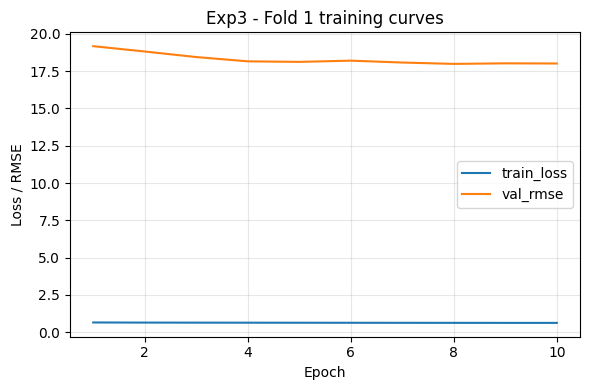

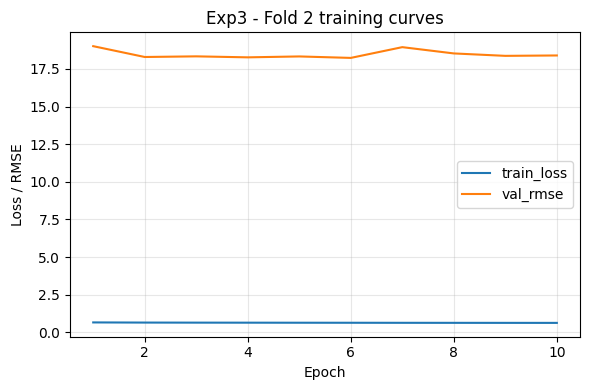

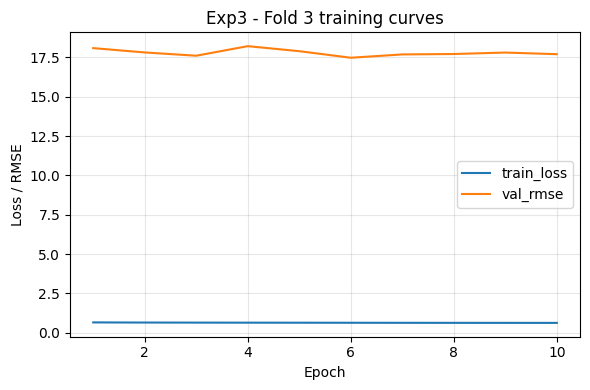

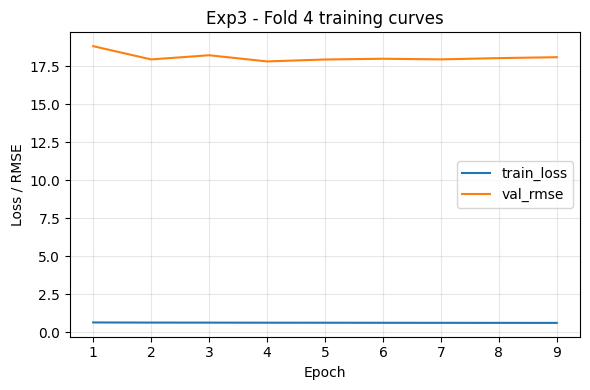

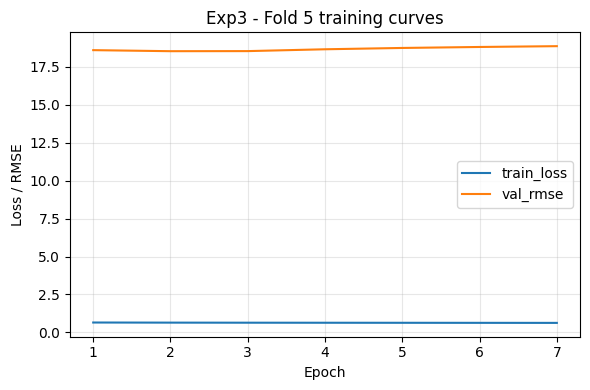

In [ ]:
#  Training curves (per Sturges hist later)

for fold in [1, 2, 3, 4, 5]:
    hist_path = os.path.join(out_dir, f"history_fold{fold}.csv")
    if not os.path.exists(hist_path):
        continue
    hist = pd.read_csv(hist_path)

    plt.figure(figsize=(6,4))
    plt.plot(hist["epoch"], hist["train_loss"], label="train_loss")
    plt.plot(hist["epoch"], hist["val_rmse"], label="val_rmse")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / RMSE")
    plt.title(f"Exp3 - Fold {fold} training curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


> The difference in both train and validation graphs lines are due to the BCE and RMSE, the model is trained on BCE Loss while for the validation data, RMSE is calculated

In [ ]:
#  Inspect worst error rows

errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


,Id,ytrue,oof_pred,abs_err
0,4c1e05895368c997fdd709bbd1ac3dae,2,87.013420,85.013420
1,9fdfa0708e98d8320e0b526315bb264a,7,90.402122,83.402122
2,d00e5d29d4ec09de1e0e0ebec41b2d03,5,88.274315,83.274315
3,346650fd7c4fcdcbd7a119436881e52a,3,82.419151,79.419151
4,48a66727373de4e7fa7bb3331cd9acc8,96,18.110155,77.889845


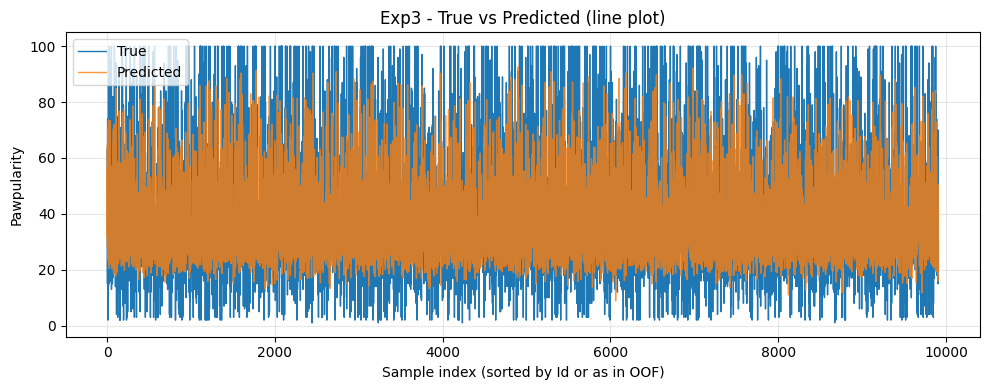

In [9]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_error_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp3")





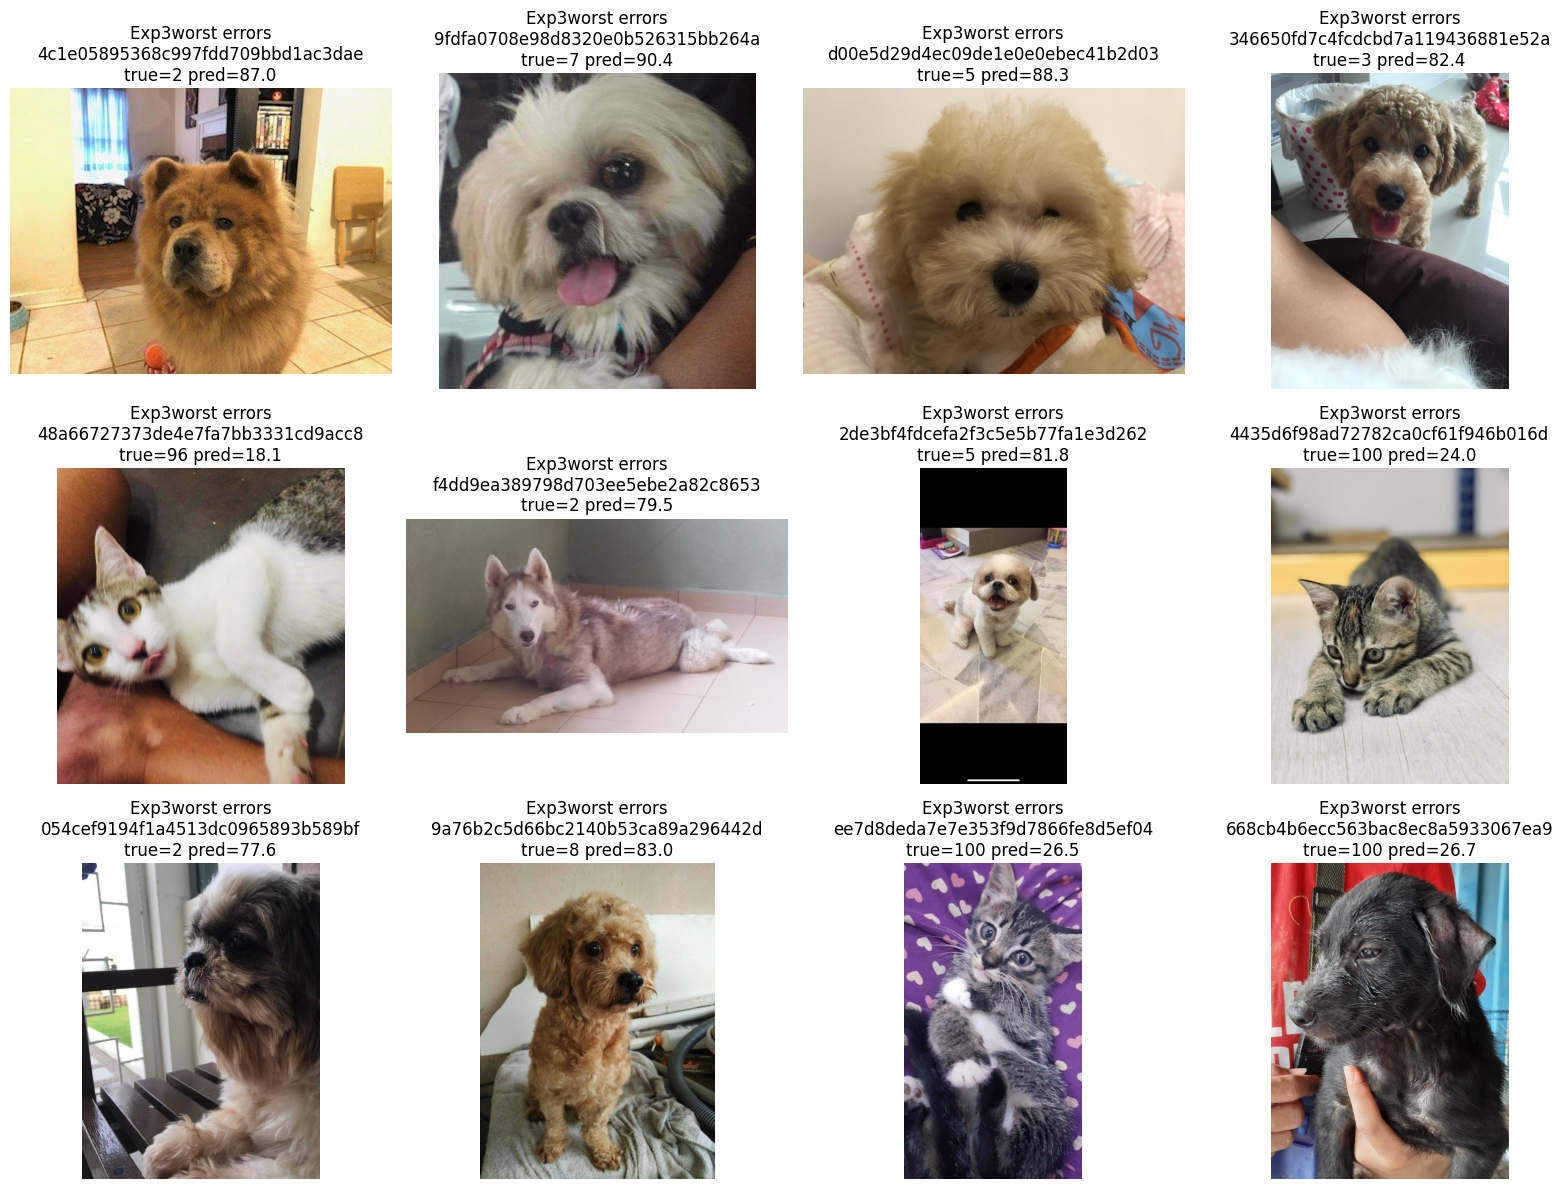

In [10]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_error_images_grid(err_df, img_folder, n=12, title_prefix="Exp3worst errors")